# COVID-19 modelamiento Santiago, Chile
Autor: Taco de Wolff\
Fecha: 10 abril 2020

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from epidemic import *

model = ModelReport2()

In [2]:
df_infectados = pd.read_csv('data/chile_minsal_infectados.csv', sep=';', index_col=0)
df_infectados = df_infectados.transpose()
df_infectados.index = pd.to_datetime(df_infectados.index, format='%d-%b') + pd.offsets.DateOffset(years=120)

df_fallecidos = pd.read_csv('data/chile_minsal_fallecidos.csv', sep=';', index_col=0)
df_fallecidos = df_fallecidos.transpose()
df_fallecidos.index = pd.to_datetime(df_fallecidos.index, format='%d-%b') + pd.offsets.DateOffset(years=120)

df_hospitalizados = pd.read_csv('data/chile_hospitalizados.csv', sep=';', index_col=0)
df_hospitalizados.index = pd.to_datetime(df_hospitalizados.index, dayfirst=True)
df_hospitalizados = df_hospitalizados[:np.datetime64('2020-03-26')]

data = pd.DataFrame({
    'I_cases': df_infectados['Región Metropolitana'],
    'D': df_fallecidos['Región Metropolitana'],
    'H_total': df_hospitalizados['Total'],
})

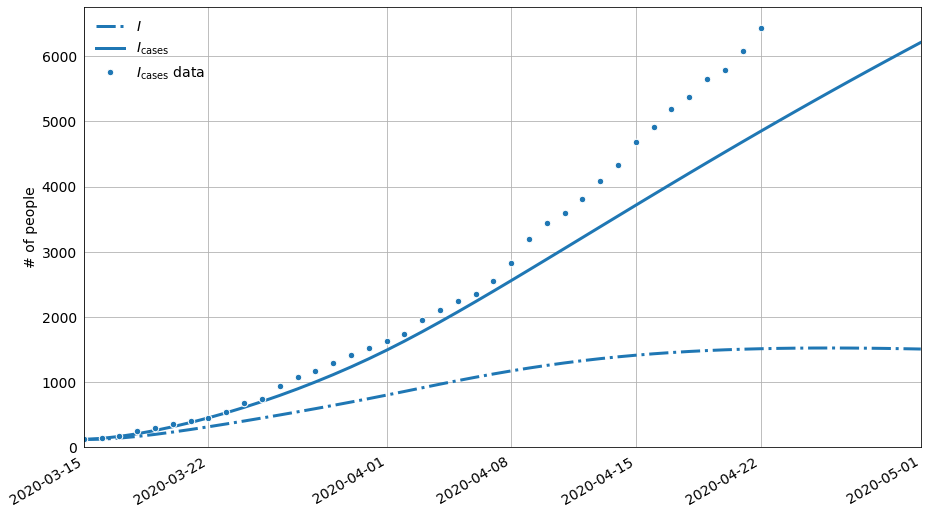

In [3]:
t0 = np.datetime64('2020-03-15')
tmax = np.datetime64('2020-05-01')

I0 = data['I_cases'].loc[t0]
H0 = data['H_total'].loc[t0]

x = [
    0.74,   # E0
    10.3,   # Im0
    0.38,   # CE
    0.75,   # CIm
    0.165,  # βI
    0.2,    # γE
    0.1,    # γIm
    0.1,    # γI
    0.1667, # γH
    0.1,    # γHc
    0.85,   # φIR
    0.85,   # φHR
    0.1,    # φD
]

x_bounds = [
    (0,20),
    (0,20),
    (0.0,0.4),  
    (0.0,0.9),
    (0.0,0.75),
    (0.17,0.25),
    (0.07,0.14),
    (0.07,0.14),
    (0.1,0.5),
    (0.0625,0.14),
    (0.3,0.9),
    (0.3,0.9),
    (0,0.5),
]

def x_params(E0, Im0, CE, CIm, βI, γE, γIm, γI, γH, γHc, φIR, φHR, φD):
    y0 = {
        'S': 5.624e6,
        'E': E0 * I0,
        'Im': Im0 * I0,
        'I': I0,
        'H': H0,
        'Hc': 0,
        'R': 0,
        'D': 0,
    }
    
    λ1 = np.datetime64('2020-04-01')
    κ1 = 0.1
    α2 = 0.5
    α = lambda t: 1.0 if t < λ1 else α2 + (1.0-α2)*np.exp(-κ1*(t-λ1)/np.timedelta64(1,'D'))
    return y0, lambda t: {
        'βE': α(t)*CE*βI,
        'βIm': α(t)*CIm*βI,
        'βI': α(t)*βI,
        'βH': 0.0,
        'βHc': 0.0,
        'γE': γE,
        'γIm': γIm,
        'γI': γI,
        'γH': γH,
        'γHc': γHc,
        'μb': 3.57e-5,
        'μd': 1.57e-5,
        'φEI': 0.5,
        'φIR': φIR,
        'φHR': φHR,
        'φD': φD,
    }

santiago = Epidemic(model, t0, tmax, data=data)
santiago.run(*x_params(*x))
santiago.plot(cols=['I', 'I_cases'])

2020-04-27 17:43:18,188 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=11 
2020-04-27 17:58:17,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.992706190864052, best pos: [3.39206344 1.71013338 0.23385764 0.37191441 0.30578198 0.20308878
 0.10092688 0.11177271 0.11817857 0.10946336 0.36433654 0.30041802
 0.09798498]


Parameter,Value,Range
E0,3.392,"[0, 20]"
Im0,1.71,"[0, 20]"
CE,0.2339,"[0, 0.4]"
CIm,0.3719,"[0, 0.9]"
βI,0.3058,"[0, 0.75]"
γE,0.2031,"[0.17, 0.25]"
γIm,0.1009,"[0.07, 0.14]"
γI,0.1118,"[0.07, 0.14]"
γH,0.1182,"[0.1, 0.5]"
γHc,0.1095,"[0.0625, 0.14]"


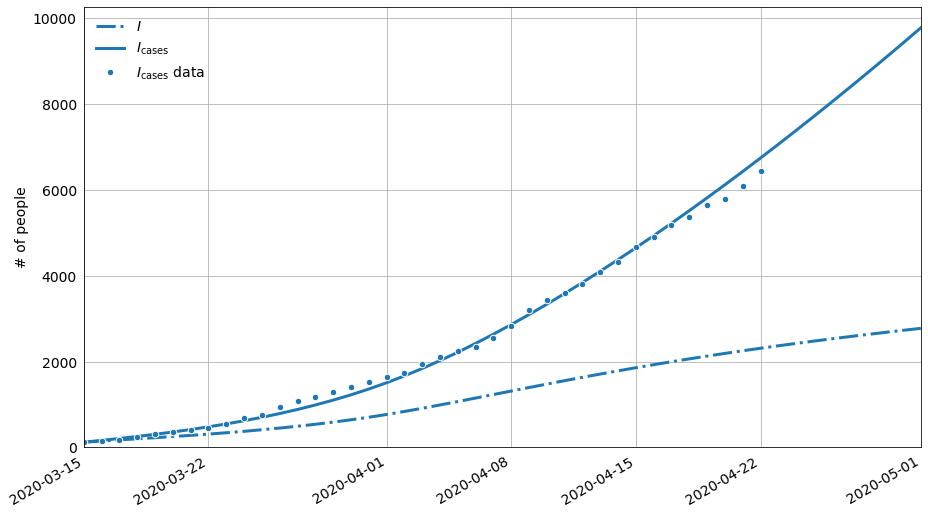

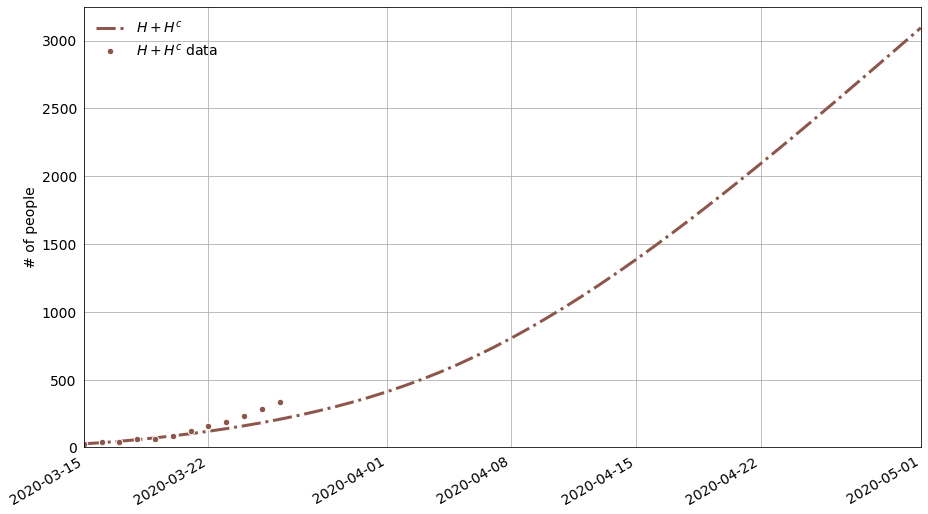

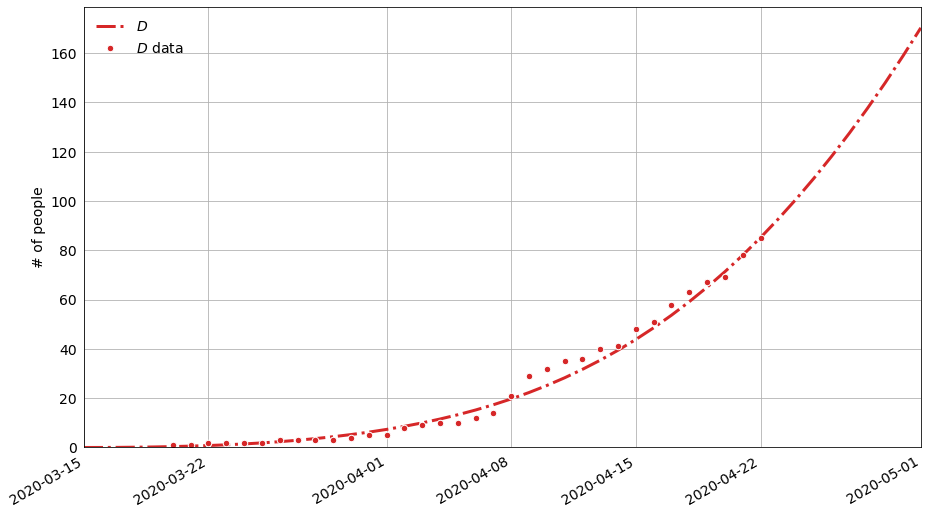

Parameter,Value,Date
max(I),2776,2020-05-01
max(H),2007,2020-05-01
max(Hc),1086,2020-05-01
max(D),170,2020-05-01


In [4]:
options = {
    'bayesian': {
        'n_calls': 150,
        'n_random_starts': 20,
    },
    'annealing': {
        'seed': 1234,
        'fast': True,
    },
    'L-BFGS-B': {
        'eps': 1e-12,
    },
}

for method in ['PSO']:#['annealing', 'L-BFGS-B']:
    opt = {}
    if method in options:
        opt = options[method]
    x = santiago.optimize(x, x_bounds, x_params, method=method, **opt)

santiago.print_x_params(x, x_bounds, x_params)
santiago.plot(cols=['I', 'I_cases'])
santiago.plot(cols=['H_total'])
santiago.plot(cols=['D'])
santiago.print_stats()

In [5]:
santiago.param_sensitivity(x, x_bounds, x_params)

,*,D,I_cases,H_total
E0,0.00707704,0.013266,0.0104629,0.0463754
Im0,0.00530084,0.00979685,0.000999112,0.0130162
CE,0.0523745,0.318577,0.215132,0.167226
CIm,0.0258688,0.17936,0.128476,0.0926224
βI,0.124237,0.965166,0.711481,0.457505
γE,0.133975,0.24286,0.142538,0.723889
γIm,0.000721641,0.276472,0.262539,0.0652807
γI,0.407866,0.361625,0.614366,1.91657
γH,0.122818,0.424047,0,0.33165
γHc,0.185156,0.476311,0,0.0381915
